##### Copyright 2024 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# PDF parsing for semantic retrieval systems

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://ai.google.dev/docs/pdf_parsing_for_semantic_retrieval_systems"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on ai.google.dev</a>
  </td>
    <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/docs/pdf_parsing_for_semantic_retrieval_systems.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/docs/pdf_parsing_for_semantic_retrieval_systems.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://ai.google.dev/tutorials/pdf_parsing_for_semantic_retrieval_systems"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

Advanced Retrieval Augmented Generation (RAG) systems often associate some kind of metadata to stored chunks/documents in order to increase efficiency of the retrieval process. This process of **context enrichment** with additional metadata is demonstrated in this tutorial.

This notebook will walk you through a workflow to parse your PDF files and add custom metadata to your documents using `gemini-vision-pro`'s image understanding abilities.


## Setup

### Authenticate

The Gemini API lets you tune models on your own data. Since it's your data and
your tuned models need stricter access controls than API-Keys can provide.

Before you can run this tutorial, you'll need to
[setup OAuth for your project](oauth_quickstart.ipynb).


In Colab the easiest way to get setup is to copy the contents of your `client_secret.json` file into Colab's "Secrets manager" (under the key icon in the left panel) with the secret name `CLIENT_SECRET`.


This gcloud command turns the `client_secret.json` file into credentials that can be used to authenticate with the service.

> Important: If you're running this in Colab, **don't just click the link it prints**. That will fail. Follow the instructions and copy the `gcloud` command it prints to your local machine and run it there, then paste the output from your local machine back here.

In [ ]:
try:
  from google.colab import userdata
  import pathlib
  pathlib.Path('client_secret.json').write_text(userdata.get('CLIENT_SECRET'))

  # Use `--no-browser` in colab
  !gcloud auth application-default login --no-browser --client-id-file client_secret.json --scopes='https://www.googleapis.com/auth/cloud-platform,https://www.googleapis.com/auth/generative-language.retriever,https://www.googleapis.com/auth/generative-language.tuning'
except ImportError:
  !gcloud auth application-default login --client-id-file client_secret.json --scopes='https://www.googleapis.com/auth/cloud-platform,https://www.googleapis.com/auth/generative-language.retriever,https://www.googleapis.com/auth/generative-language.tuning'

### Install the client library and other dependencies

In [ ]:
!pip install -qU google-generativeai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 3.2 MB/s eta 0:00:00


You will be using [`pdf2image`](https://pypi.org/project/pdf2image/) package to convert PDF files to images and [`PyPDF2`](https://pypi.org/project/PyPDF2/) package to mine text from the PDF files. `pdf2image` requires the `poppler-utils` package to function. Please refer to the [installation guide](https://pypi.org/project/pdf2image/) here.

In [1]:
!apt-get install -q poppler-utils
!pip install -q pdf2image
!pip install -q PyPDF2

Reading package lists...
Building dependency tree...
Reading state information...
poppler-utils is already the newest version (22.02.0-2ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


You will be using [`RecursiveCharacterTextSplitter`](https://python.langchain.com/docs/modules/data_connection/document_transformers/recursive_text_splitter) to split text into smaller chunks.

In [2]:
!pip install -qU langchain-text-splitters

### Import libraries

In [3]:
from tqdm.notebook import tqdm
import textwrap
from IPython.display import Markdown, display
from PIL import Image
from typing import Any, Iterable
import pprint
import os

import google.ai.generativelanguage as glm
import google.generativeai as genai
from google.generativeai import retriever
from google.generativeai.types.retriever_types import MetadataFilter, Condition, Corpus, CustomMetadata

from google.colab import files

from pdf2image import convert_from_path, convert_from_bytes

from PyPDF2 import PdfReader

from langchain_text_splitters import RecursiveCharacterTextSplitter

def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

## Upload PDF files

Next, you will upload all the PDF files you wish to parse for your RAG system.

In [4]:
pdfs = files.upload()

Saving 2210.03629.pdf to 2210.03629.pdf
Saving legalEase_new.pdf to legalEase_new.pdf


## Helper functions

As discussed in the prior sections, your goal is to mine information from the PDF files and convert the files into sets of images which would allow the `gemini-pro-vision` model to analyze them.

In [5]:
# Define models for future use
vision_model = genai.GenerativeModel('gemini-1.0-pro-vision-latest')
text_model = genai.GenerativeModel('gemini-1.0-pro-latest')

### Mine page-wise text from PDF files.

In [6]:
def pdf2text(path: str | os.PathLike) -> list[int, str]:
  """Extracts text from a PDF file."""
  reader = PdfReader(path)
  for idx, page in enumerate(reader.pages[:5]): # for demonstration purposes only 2 pages are considered
    # imgs = [img for img in page.images]
    yield idx, page.extract_text()


In [7]:
extractor = iter(pdf2text('2210.03629.pdf'))
page_no, text = next(extractor)
print(f"page number: {page_no}")
print(text)

page number: 0
Published as a conference paper at ICLR 2023
REAC T: S YNERGIZING REASONING AND ACTING IN
LANGUAGE MODELS
Shunyu Yao*,1, Jeffrey Zhao2, Dian Yu2, Nan Du2, Izhak Shafran2, Karthik Narasimhan1, Yuan Cao2
1Department of Computer Science, Princeton University
2Google Research, Brain team
1{shunyuy,karthikn}@princeton.edu
2{jeffreyzhao,dianyu,dunan,izhak,yuancao}@google.com
ABSTRACT
While large language models (LLMs) have demonstrated impressive performance
across tasks in language understanding and interactive decision making, their
abilities for reasoning (e.g. chain-of-thought prompting) and acting (e.g. action
plan generation) have primarily been studied as separate topics. In this paper, we
explore the use of LLMs to generate both reasoning traces and task-speciﬁc actions
in an interleaved manner, allowing for greater synergy between the two: reasoning
traces help the model induce, track, and update action plans as well as handle
exceptions, while actions allow it to in

### Convert PDF files to images

In [8]:
def pdf2imgs(file: str | os.PathLike | bytes) -> Iterable[Image.Image]:
  """Converts PDF file to PIL.Image.Image objects.
  Single page can have multiple images.
  """
  images = []
  if isinstance(file, bytes):
    images = convert_from_bytes(file)
  else:
    images = convert_from_path(file)

  for image in images:
    yield image

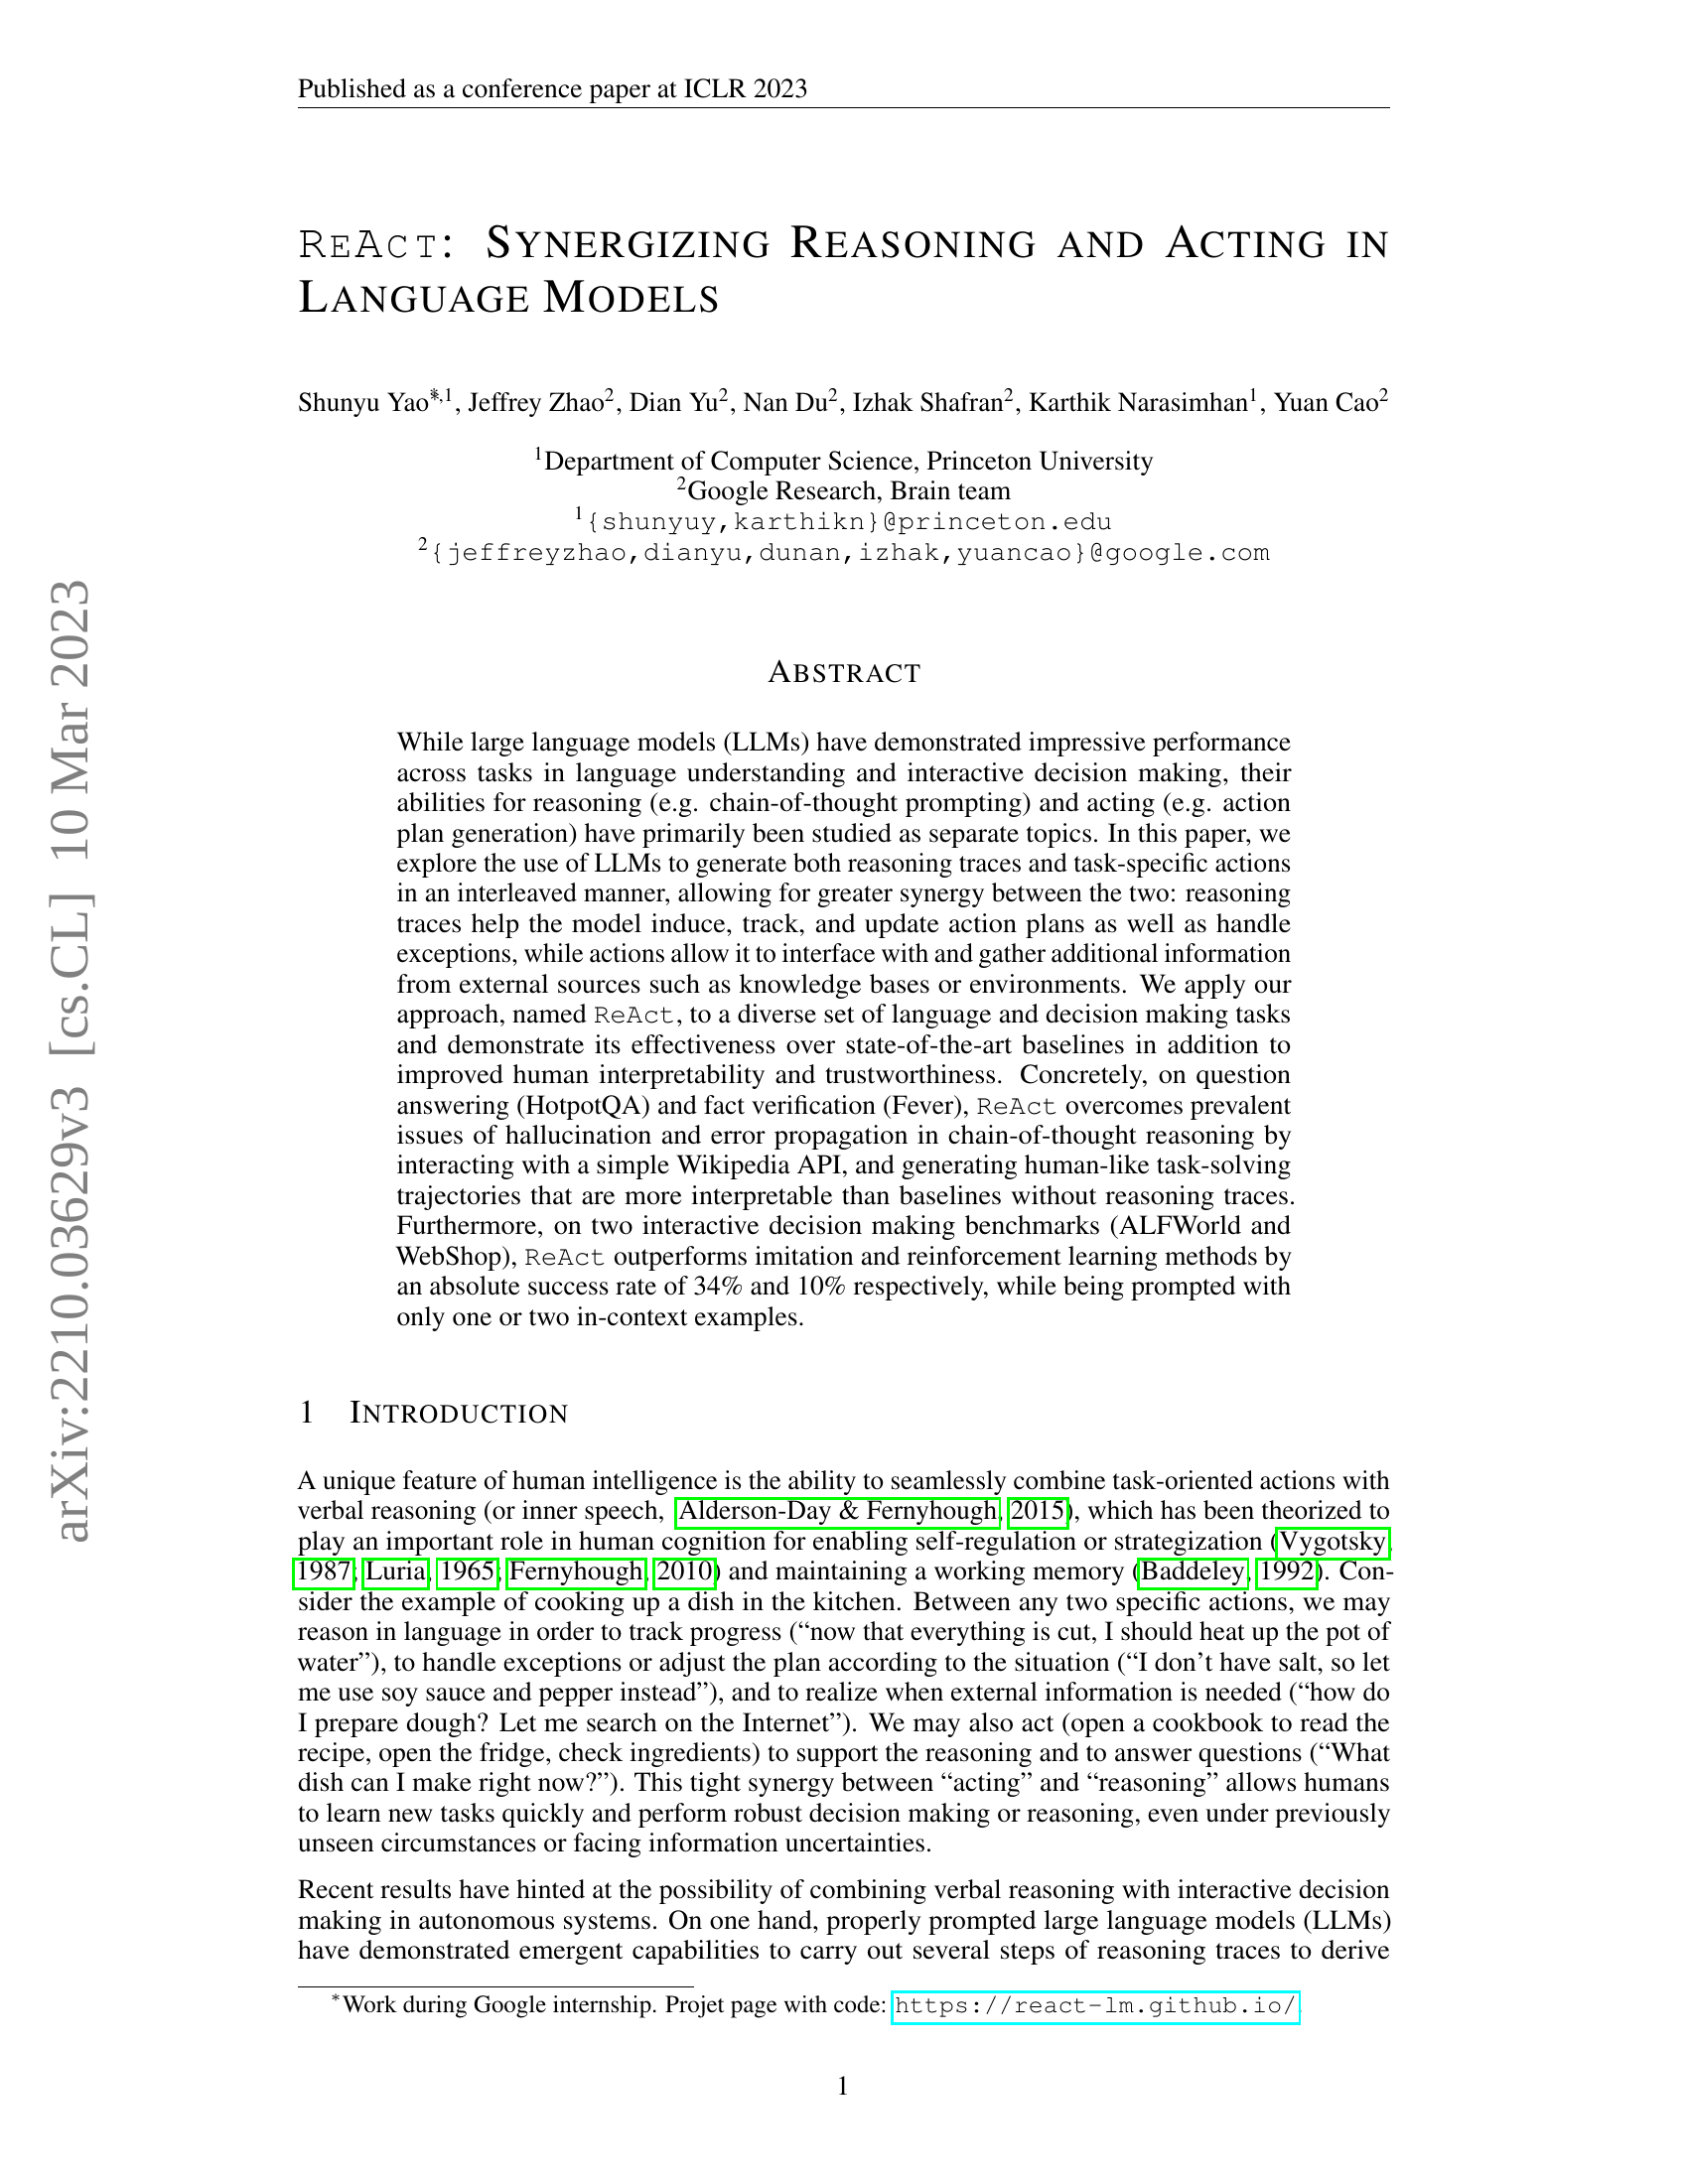

In [9]:
images = iter(pdf2imgs('2210.03629.pdf'))
display(next(images))

### Image analysis helper function

Your goal is to extract the following metadata from the image analysis of every PDF file's page:


*   Page number.
*   Key-words from the page's content.
*   Questions that can be answered with the help of the page's content.
*   Suitable title for the page.
*   links present in the page.


The outputs of the image analysis must follow a strict structured format, so that it would be easier for you to use this data directly as metadata with minimal modifications. This requirement makes your use case a prime candidate to use [structured data extraction using function calling](https://ai.google.dev/tutorials/structured_data_extraction).


#### Structured data extraction

In [10]:
def _extract_structured_data(
    title: str,
    key_words: list[str],
    questions: list[str],
    links: list[str],
  ) -> dict[str, Any]:
  """Structred data extraction from image analysis."""
  return {
      'title': title,
      'key_words': key_words,
      'questions': questions,
      'links': links,
  }

Pass this function to `tools` parameter.

> Note: At this time function calling is not supported by `gemini-pro-vision` hence, you will first try to generate metadata with `gemini-vision-pro` and then you will pass this response to `gemini-pro` to extract the data as you need.


In [11]:
schema = glm.Tool(
    function_declarations=[glm.FunctionDeclaration(
    name="structured_data_extraction",
    description=textwrap.dedent("""\
    Structred data extraction from image analysis.
    """),
    parameters=glm.Schema(
        type=glm.Type.OBJECT,
        properties={
            "title": glm.Schema(type=glm.Type.STRING),
            "key_words": glm.Schema(type=glm.Type.ARRAY),
            "questions": glm.Schema(type=glm.Type.ARRAY),
            "links": glm.Schema(type=glm.Type.ARRAY),
        },
        # required=['title', 'key_words', 'questions', 'links']
    )
)])

In [12]:
vision_model = genai.GenerativeModel('gemini-1.0-pro-vision-latest')

text_model = genai.GenerativeModel('gemini-1.0-pro-latest',
                                   tools=[schema])

In [13]:
def _image_analysis(img):
  """Extracts metadata from the image provided and returns it in a structured dict."""
  prompt = textwrap.dedent(f"""
  You are an expert image analyzer. Given an image of a PDF page, your job is to write the following for each and every image.
  1. Generate key-words that matches the content from the image. (at most 10.)
  2. Suggest a one-word title for the image.
  3. Generate 1-2 short questions from the image.
  4. Extract links that are present in the image.

  Your answer should follow the following format.
  ** 1. Key-words**
  [list of relevant key-words to descibe the content of the image]

  **2. Title**
  Suggest a one-word title based on the content here.

  **3. Questions**
      [lst of generated questions here...]
      ....

  **4. Links**
  [https://...., https://....]

  Do not print any other information, strictly follow the format mentioned.

  Now, here is the image.
  """)
  res = vision_model.generate_content([prompt, img])
  return res.text

In [14]:
res = _image_analysis(next(images))
to_markdown(res)

>  **1. Key-words**
> reinforcement learning, language grounding, multimodal reasoning, AI2Thor
> 
> **2. Title**
> Reasoning
> 
> **3. Questions**
> 1. What is the task in the image?
> 2. What are the baselines compared in the image?
> 
> **4. Links**
> [https://arxiv.org/pdf/2204.06004.pdf]

In [15]:
def extract_structured_data(res: str) -> dict[str, Any]:
  fc = text_model.generate_content(textwrap.dedent(f"""\
  Given a response, your job is to extract data present in the text
  with the help of tools provided to you.

  Gemini-pro-vision's response:
  {res}
  """)).candidates[0].content.parts[0].function_call

  fc_args = fc.args

  metadata = _extract_structured_data(
      title=fc_args.get('title', ""),
      key_words=fc_args.get('key_words'),
      questions=fc_args.get('questions'),
      links=fc_args.get('links'),
  )

  return metadata

In [16]:
metadata = extract_structured_data(res)
print(f"Generated Metadata:")
pprint.pprint(metadata)

Generated Metadata:
{'key_words': ['reinforcement learning', 'language grounding', 'multimodal reasoning', 'AI2Thor'],
 'links': ['https://arxiv.org/pdf/2204.06004.pdf'],
 'questions': ['What is the task in the image?', 'What are the baselines compared in the image?'],
 'title': 'Reasoning'}


In [17]:
def image_analysis(img):
  res = _image_analysis(img)
  return extract_structured_data(res)

Neat! The models were successfuly able to extract your custom metadata from the given information sources!

## PDF ingestion pipeline

Now that you are all set with helper functions, it is time to build an end-to-end data pipeline which would parse your PDF files and add custom metadata to them. This additional context will help your retrieval systems to perform better.

To get you started on building the pipeline, this section will walk you through the following steps:


1.   Extract text and perform image analysis on uploaded files.
2.   Split your data into chunks and add custom metadata for context enrichment.
3.   Use the Python SDK for Gemini API to create your Corpus, Documents and Chunks.
4.   Query the Corpus with custom metadata filters.


### Create chunks

You will chunk your data page-wise for this tutorial.

In [21]:
def parse_and_analyse_images(pdfs: dict[str, bytes]) -> Corpus:
  # create a corpus
  corpus = retriever.create_corpus(name="pdf-with-metadata-for-advanced-rag")

  text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=200,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
  )

  # iter through all PDF files.
  for filename, file_bytes in pdfs.items():
    print(f"Extracting data from file: {filename}")

    # get the iterator to convert pages into images
    images = iter(pdf2imgs(file_bytes))

    # create a document named `filename` within the corpus
    # document = corpus.create_document(name=filename.replace('.', '-'))

    try:
      num_pages = len(PdfReader(filename).pages[:5])
      # # add number of pages to the document's metadata
      # document.custom_metadata.append(glm.CustomMetadata(
      #     key="num_pages", numeric_value=num_pages
      # ))

      with tqdm(total=num_pages) as pbar:
        # start extracting page-wise text from the file
        for page_id, page_content in pdf2text(filename):

          # prepare `chunks` to use `batch_create_chunks` after each page
          chunks :list[tuple[str, str, list[glm.CustomMetadata]]] = [] # name, data, custom_metadata
          # try to get the image of this page
          page_img = next(images)

          # extract structured data
          metadata = image_analysis(img=page_img)

          # as discussed earlier, add `title`, `summary`, `questions`, and `links` to document's metadata.
          metadata = [
              CustomMetadata(key=metadata_key, value=metadata_value) if metadata_key == "title"
              else CustomMetadata(key=metadata_key, value=list(metadata_value)[:10] if metadata_value else ["no_link_found"])
              for (metadata_key, metadata_value) in metadata.items()
          ]

          # add page number to chunk's metadata
          page_id_metadata = [
              CustomMetadata(
                  key="page_num",
                  value=int(page_id) + 1
              )
          ]
          metadata.extend(page_id_metadata)
          # print(metadata)


          # create a document named `{filename}-{page_id}` within the corpus
          document = corpus.create_document(
              name=f"{filename.lower().replace('.', '-').replace(' ', '-').replace('_', '-')}-{page_id}",
              custom_metadata=metadata
          )

          passages = text_splitter.split_text(page_content)
          for idx, passage in enumerate(passages):
            tup = (f"chunk-{page_id}-{idx}", passage)
            chunks.append(tup)

          pbar.update(1)
          _ = document.batch_create_chunks(chunks)

    except StopIteration:
        print(f"Unexpected end of file: `{filename}`, hence skipping...")

  return corpus

In [22]:
for corpus in genai.retriever.list_corpora():
  genai.retriever.delete_corpus(name=corpus.name, force=True)

In [23]:
corpus = parse_and_analyse_images(pdfs)

Extracting data from file: 2210.03629.pdf


  0%|          | 0/5 [00:00<?, ?it/s]

Extracting data from file: legalEase_new.pdf


  0%|          | 0/5 [00:00<?, ?it/s]

In [24]:
corp = genai.retriever.get_corpus('pdf-with-metadata-for-advanced-rag')
for chunk in corp.list_documents():
  print(chunk.to_dict())

{'name': 'corpora/pdf-with-metadata-for-advanced-rag/documents/2210-03629-pdf-0', 'display_name': '', 'custom_metadata': [{'key': 'title', 'string_value': 'REACT'}, {'key': 'key_words', 'string_list_value': {'values': ['reasoning', 'acting']}}, {'key': 'questions', 'string_list_value': {'values': ['no_link_found']}}, {'key': 'links', 'string_list_value': {'values': ['no_link_found']}}, {'key': 'page_num', 'numeric_value': 1.0}]}
{'name': 'corpora/pdf-with-metadata-for-advanced-rag/documents/2210-03629-pdf-1', 'display_name': '', 'custom_metadata': [{'key': 'title', 'string_value': 'Language Grounded Navigation'}, {'key': 'key_words', 'string_list_value': {'values': ['reinforcement learning', 'MDP', 'POMDP', 'language grounding', 'language-conditioned navigation']}}, {'key': 'questions', 'string_list_value': {'values': ['What is the relationship between language grounding and reinforcement learning?', 'How can language be used to condition navigation in a reinforcement learning setting?

### Query the corpus

The Gemini API lets you query your corpora/documents/chunks objects with `MetadataFilter`s. To learn more about how querying works with these filters please refer to the [Semantic retriever quickstart](https://ai.google.dev/docs/semantic_retriever#overview). You will use this functionality and make use of the custom metadata that you have stored in the previous section to retrieve your data efficiently.

In [25]:
user_query = "What is LLMs?"

doc_level_filter_1 = MetadataFilter(
    key='document.custom_metadata.page_num',
    conditions=[Condition(value=2, operation="LESS")]
)

doc_level_filter_2 = MetadataFilter(
    key='document.custom_metadata.key_words',
    conditions=[Condition(value="QA", operation="EXCLUDES"),
                Condition(value="LegalEase", operation="INCLUDES")]
)

doc_level_filter_3 = MetadataFilter(
    key='document.custom_metadata.title',
    conditions=[Condition(value="REACT", operation="EQUAL")]
)

relevant_chunks = corpus.query(
    query=user_query,
    metadata_filters=[doc_level_filter_1, doc_level_filter_2, doc_level_filter_3],
    results_count=10
)

`relevant_chunks` has chunks that matched our search results. Each chunk returned has a `chunk_relevance_score` and `chunk`. Where `chunk_relevance_score` deontes the degree to which the `user_query` is semantically similar to the contents from `chunk`.

Note how the chunks are ordered in decreasing order of the `relevance_score`.

In [26]:
relevant_chunks = list(relevant_chunks)
print(len(relevant_chunks))

10


Inspect the top candidate

In [27]:
for chunk in relevant_chunks:
  print(chunk.chunk, chunk.chunk_relevance_score)

Chunk(name='corpora/pdf-with-metadata-for-advanced-rag/documents/2210-03629-pdf-0/chunks/chunk-0-4',
      data=ChunkData(string_value=('plan generation) have primarily been studied as separate topics. In this '
                                   'paper, we\n'
                                   'explore the use of LLMs to generate both reasoning traces and task-speciﬁc '
                                   'actions')),
      custom_metadata=[],
      state=<State.STATE_ACTIVE: 2>,
      create_time=datetime.datetime(2024, 3, 18, 6, 26, 36, 982589),
      update_time=datetime.datetime(2024, 3, 18, 6, 26, 38, 476005)) 0.7122827
Chunk(name='corpora/pdf-with-metadata-for-advanced-rag/documents/2210-03629-pdf-0/chunks/chunk-0-2',
      data=ChunkData(string_value=('1{shunyuy,karthikn}@princeton.edu\n'
                                   '2{jeffreyzhao,dianyu,dunan,izhak,yuancao}@google.com\n'
                                   'ABSTRACT\n'
                                   'While large langu

## Next steps

To learn how to use other services in the Gemini API, visit the [Python quickstart](https://ai.google.dev/tutorials/python_quickstart). To learn more about how you can use the embeddings, check out the [examples](https://ai.google.dev/examples?keywords=embed) available.